# Capstone Project - The Battle of Neighborhoods


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Collection](#data_collection)
* [Method](#method)
* [Analysis](#analysis)
* [Results and Discussion](#results_and_discussion)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this hypothetical scenario a successful restaurateur is looking to expand their business into a new city.  Their Indian restaurant has been the talk of Wellington City for 25 years and now the eldest daughter is keen to open and run a restaurant of her own.  She would like to expand the family business into Auckland, New Zealand’s largest city.  

Auckland is home to 1.6 million people covering an area 1,000 km2.  The daughter is confident she can establish a restaurant and build a reputation in fine dining that will rival her parents in Wellington.  However, not knowing Auckland city well, she is keen to identify the best neighbourhood to open her first fine dining Indian restaurant.  

Based on the family’s experiences with their restaurant in Wellington, seeking out an area that already attracts diners who enjoy Indian cuisine would be a good indicator for the location of the new restaurant.  

## Data Collection  <a name="data_collection"></a>

Within the limited scope of this report the following data was needed.

### Part 1 - Data Preparation:

*	A list of Auckland neighbourhoods
*	The post codes of each neighbourhood
*   Latitude and longitude co-ordinates for each post code.

This data was found at the following website: https://www.geonames.org/postalcode-search.html?q=auckland&country=NZ , and was scrapped using Python script to provide the relevant data needed to solve this problem.  

The Folium library was be used as a visual aid while examining the data, rendering maps of Auckland’s neighbourhoods.
Later in the analysis folium was be used to show the different venue clusters that where identified using machine learning methods. 

Once the neighbourhood data was arranged into a workable data frame, The Foursquare API software identified:
*	The different types of venues (e.g. restaurants, parks) in each neighbourhood.
*	The popularity of each venue in each of these neighbourhoods.
*   The focus of our search will be on the Food category, specifically on Indian cuisine

### Part 2 - Data Preparation: 

The client wishes to attract returning patrons who are seeking a high-end dining experience.  An initial way to explore this question would be to look at household incomes in the potential neighbourhoods, as household incomes (or disposable incomes) may provide an indication of the frequency potential customers might seek to dine out.  Higher earners may be more inclined to seek out the more exclusive dining experiences the client wishes to provide in her restaurant.

Household income data was taken from New Zealand's most recent Census (2018).  These were downloaded as a.csv file from https://www.stats.govt.nz/ and included latitude and longitude information. Household income data lacked postcode and neighbourhood information.  Using latitude and longitude data the additional address information was obtained from https://nominatim.org/ .

Another concern for the client is how centrally located the neighbourhood is within the city.  Her preference is to establish her first restaurant within the inner-city neighbourhoods, although she will not dismiss and outlying neighbourhood if the conditions are favourable.  This feature is discribed in the "Methods section".



### Libraries

In [37]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

# distance from 2 sets of latitude and longitude 
from math import sin, cos, sqrt, atan2, radians

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Auckland City Data

The initial data was scrapped from https://www.geonames.org/postalcode-search.html?q=auckland&country=NZ.

Then cleaned into a data frame of the relevent information:
* PostCode
* Neighbourhood name
* Latitude
* Longitude



In [38]:
AKL_data = pd.read_html('https://www.geonames.org/postalcode-search.html?q=auckland&country=NZ')

In [39]:
type(AKL_data)
len(AKL_data)
AKL_df = AKL_data[2]
AKL_df.head()

,Unnamed: 0,Place,Code,Country,Admin1,Admin2,Admin3
0,1.0,Blockhouse Bay,0600,New Zealand,Auckland,NaN,NaN
1,NaN,-36.918/174.7,-36.918/174.7,-36.918/174.7,-36.918/174.7,-36.918/174.7,-36.918/174.7
2,2.0,Kelston,0602,New Zealand,Auckland,NaN,NaN
3,NaN,-36.898/174.66,-36.898/174.66,-36.898/174.66,-36.898/174.66,-36.898/174.66,-36.898/174.66
4,3.0,Huia,0604,New Zealand,Auckland,NaN,NaN


In [40]:
AKL_df.columns = ['Unnamed', 'Neighbourhoods', 'PostCode', 'Country', 'Admin1', 'Admin2', 'Admin3']
AKL_dfDrop = AKL_df.drop(['Unnamed','Admin1','Admin2', 'Admin3','Country'], axis=1)
AKL_dfDrop = AKL_dfDrop.dropna(axis = 0, how ='any')
AKL_dfDrop.head()

,Neighbourhoods,PostCode
0,Blockhouse Bay,0600
1,-36.918/174.7,-36.918/174.7
2,Kelston,0602
3,-36.898/174.66,-36.898/174.66
4,Huia,0604


In [41]:
print(AKL_dfDrop.shape)
print(AKL_df.dtypes)

(400, 2)
Unnamed           float64
Neighbourhoods     object
PostCode           object
Country            object
Admin1             object
Admin2             object
Admin3             object
dtype: object


In [42]:
AKL_geo = AKL_df['PostCode']
AKL_geoSplit = AKL_geo.str.split("/", n = 1, expand = True) 
AKL_geoSplit.columns = ['Latitude', 'Longitude']
AKL_geoSplit.head()

,Latitude,Longitude
0,0600,None
1,-36.918,174.7
2,0602,None
3,-36.898,174.66
4,0604,None


In [43]:
AKL_geoSplit2 = AKL_geoSplit.iloc[::2, 0]
AKL_geoSplit2.columns = ['PostCode']

In [44]:
AKL_geoSplit3 = AKL_geoSplit.iloc[1::2, :]
AKL_Geodata = pd.concat([AKL_geoSplit3, AKL_geoSplit2], axis=0, ignore_index=True)
AKL_Geodata.columns = ['Latitude', 'Longitude', 'NaN']
AKL_Geodata2 = AKL_Geodata.drop(['NaN'], axis=1)
AKL_Geodata2['Latitude'] = AKL_Geodata2['Latitude'].astype(float)
AKL_Geodata2['Longitude'] = AKL_Geodata2['Longitude'].astype(float)
AKL_Geodata2.head()

,Latitude,Longitude
0,-36.918,174.700
1,-36.898,174.660
2,-36.998,174.567
3,-36.888,174.610
4,-36.867,174.583


In [45]:
AKL_Geodata3 = pd.concat([AKL_geoSplit2, AKL_geoSplit3], axis=0, ignore_index=True)
AKL_Geodata3.columns = ['PostCode', 'Latitude', 'Longitude']
AKL_Geodata4 = AKL_Geodata3.drop(['Latitude', 'Longitude'], axis=1)
AKL_LatLog = pd.concat([AKL_Geodata4, AKL_Geodata2], axis=1, sort=False)
AKL_merge = pd.merge(AKL_dfDrop,AKL_LatLog, on = 'PostCode')
AKL_merge.head()

,Neighbourhoods,PostCode,Latitude,Longitude
0,Blockhouse Bay,0600,-36.918,174.700
1,Kelston,0602,-36.898,174.660
2,Huia,0604,-36.998,174.567
3,McLaren Park,0612,-36.888,174.610
4,Swanson,0614,-36.867,174.583


In [46]:
print(AKL_merge.dtypes)
print(AKL_merge.shape)

Neighbourhoods     object
PostCode           object
Latitude          float64
Longitude         float64
dtype: object
(202, 4)


In [47]:
check_for_nan = AKL_merge.isnull().values.any()
print (check_for_nan)

False


### Median household Income Data

The initial data was scrapped from https://www.stats.govt.nz/, and contained 3 freatures, median income, latitude and longitude.

Postcodes associated with geolocations were acquired by using the centroid for each postcode's location and reverse geocoding with https://nominatim.org/ .  This data was presented in a data frame with the relevent information:

* PostCode
* Median household income
* Latitude
* Longitude

In [2]:
Income_data = pd.read_csv("C:/Users/h/Documents/Income_Median_2018smaller.csv", header = 0)
Income_data.head()

,Income_Median_2018,Latitude,Longitude
0,2800,-36.858,174.766
1,3100,-36.878,174.707
2,3300,-36.860,174.770
3,3800,-36.957,174.838
4,4300,-36.855,174.767


In [3]:
print(Income_data.shape)
print(Income_data.dtypes)

(9362, 3)
Income_Median_2018      int64
Latitude              float64
Longitude             float64
dtype: object


In [40]:
lats=Income_data['Latitude'].to_list()
lons=Income_data['Longitude'].to_list()
# Creating a zip with latitudes and longitudes
coords=list(zip(lats,lons))

In [93]:
geolocator = Nominatim(user_agent="test_app")
postcode=[]

for i in range(len(coords)):
    location = geolocator.reverse(coords[i])
    address=location.raw['display_name']
    postcode.append(address)

In [94]:
Income_data["Address"] = postcode
Income_data.head()

,Income_Median_2018,Latitude,Longitude,Address
0,34000,-37.248,175.011,"Wingfield Road, Pokeno, Waikato District, Waik..."
1,33000,-37.248,174.727,"7, Norfolk Rise, Waiuku, Franklin, Auckland, 2..."
2,28000,-37.248,174.738,"53B, Kitchener Road, Waiuku, Franklin, Aucklan..."
3,24100,-37.247,174.742,"8, Fernleigh Avenue, Waiuku, Franklin, Aucklan..."
4,26600,-37.247,175.022,"3A, Marlborough Street, Pokeno, Waikato Distri..."


In [95]:
df1 = Income_data['Address'].str.split(', ', expand=True).add_prefix('Add').fillna('')
#print(df1)

In [96]:
Code = []
for rownum in df1.index: # loop through the rows
    #print(rownum)
    #print(df1.loc[rownum,:])
    postcode = -1
    for colname in df1: #loop through the columns
        #print(colname) 
        #print(df1.loc[:,colname])
        value = str(df1.loc[rownum,colname])
        #print(value  , value.isdigit(), len(value))
        if value.isdigit() and len(value) == 4:
            postcode = value
            #print(postcode)
    if postcode == -1:
        Code.append('nan')
    else:
         Code.append(postcode)

In [102]:
df1["Code"] = Code
df1.head()

,Add0,Add1,Add2,Add3,Add4,Add5,Add6,Add7,Add8,Add9,Code
0,Wingfield Road,Pokeno,Waikato District,Waikato,2472,New Zealand / Aotearoa,,,,,2472
1,7,Norfolk Rise,Waiuku,Franklin,Auckland,2123,New Zealand / Aotearoa,,,,2123
2,53B,Kitchener Road,Waiuku,Franklin,Auckland,2123,New Zealand / Aotearoa,,,,2123
3,8,Fernleigh Avenue,Waiuku,Franklin,Auckland,2123,New Zealand / Aotearoa,,,,2123
4,3A,Marlborough Street,Pokeno,Waikato District,Waikato,2472,New Zealand / Aotearoa,,,,2472


In [104]:
df2 = df1.drop(['Add0', 'Add1', 'Add2', 'Add3','Add4', 'Add5', 'Add6', 'Add7','Add8', 'Add9'], axis = 1)
df2.head()

,Code
0,2472
1,2123
2,2123
3,2123
4,2472


In [105]:
Income_df = Income_data.join(df2)
Income_df.head()

,Income_Median_2018,Latitude,Longitude,Address,Code
0,34000,-37.248,175.011,"Wingfield Road, Pokeno, Waikato District, Waik...",2472
1,33000,-37.248,174.727,"7, Norfolk Rise, Waiuku, Franklin, Auckland, 2...",2123
2,28000,-37.248,174.738,"53B, Kitchener Road, Waiuku, Franklin, Aucklan...",2123
3,24100,-37.247,174.742,"8, Fernleigh Avenue, Waiuku, Franklin, Aucklan...",2123
4,26600,-37.247,175.022,"3A, Marlborough Street, Pokeno, Waikato Distri...",2472


In [2]:
Income_final_df = pd.read_csv("C:/Users/hldew/Documents/Capstone_week_4/Battle_of_the_neighbourhoods_Auckland_income_postcode.csv", converters={'PostCode': lambda x: str(x)})
Income_final_df.head()

,Income_Median_2018,Latitude,Longitude,PostCode,Neighbourhood
0,28300,-36.629,174.667,0312,NaN
1,36500,-36.648,174.671,0312,NaN
2,43900,-36.649,174.675,0312,NaN
3,47700,-36.639,174.657,0312,NaN
4,30200,-36.151,174.611,0505,NaN


In [3]:
print(Income_final_df.isnull().values.any())
print(Income_final_df.shape)

True
(1038092, 5)


In [4]:
Income_final_df = Income_final_df.dropna(axis = 0, how ='any')

In [5]:
print(Income_final_df.isnull().values.any())
print(Income_final_df.shape)

False
(1037005, 5)


### Map of Auckland City Neighbourhoods

Now we have a database of 202 Auckland neighbourhoods to work with we can use Folium to visualise Auckland's neighbourhoods to get an idea of how much urban sprawl the city has.

In [22]:
address = 'Auckland, NZ'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Auckland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Auckland are -36.852095, 174.7631803.


In [23]:
print('The dataframe has {} postcodes.'.format(
        len(AKL_merge['PostCode'].unique()),
        AKL_merge.shape[0]
    )
)

The dataframe has 199 postcodes.


In [24]:
# create map of Auckland using latitude and longitude values
map_AKL = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, PostCode in zip(AKL_merge['Latitude'], AKL_merge['Longitude'], AKL_merge['PostCode']):
    label = '{}'.format(PostCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_AKL)  
    
map_AKL

## Foursquare 

For this step we used the Foursquare API to build a list of venues of up to 100 candidates (the limit for free access to the FOoursquare API), within a 500 metre radius of each of Auckland’s neighbourhood centroids.  

The venue category was restricted to Food as it is assumed (within the confines of this project) that other venue categories would not impacting a potential diners choose of which type of cuisine to consume.

The category hierarchy ID codes were taken from "https://developer.foursquare.com/docs/build-with-foursquare/categories/"

Food ID: 4d4b7105d754a06374d81259

And then further subset into Indian restaurant categories: 4bf58dd8d48988d10f941735

Within this subset there were 26 listed Indian dining categories: Andhra Restaurant, Awadhi Restaurant, Bengali Restaurant, Chaat Place, Chettinad Restaurant, Dhaba, Dosa Place, Goan Restaurant, Gujarati Restaurant, Hyderabadi Restaurant, Indian Chinese Restaurant, Indian Sweet Shop, Irani Cafe, Jain Restaurant, Karnataka Restaurant, Kerala Restaurant, Maharashtrian Restaurant, Mughlai Restaurant, Multicuisine Indian Restaurant, North Indian Restaurant, Northeast Indian Restaurant, Parsi Restaurant, Punjabi Restaurant, Rajasthani Restaurant, South Indian Restaurant, Udupi Restaurant.

In [49]:
CLIENT_ID = 'BUJW5YZWI0ZXZ4YLXTO5JLHPRNZQYWAWDWPZA43XVFRFH33H' # your Foursquare ID
CLIENT_SECRET = 'AWAZOUBY1JBWVVDUCISHWDEZYAI3INUEKT2TXC4B5CRAJEKE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BUJW5YZWI0ZXZ4YLXTO5JLHPRNZQYWAWDWPZA43XVFRFH33H
CLIENT_SECRET:AWAZOUBY1JBWVVDUCISHWDEZYAI3INUEKT2TXC4B5CRAJEKE


In [27]:
AKL_merge.loc[:, 'Neighbourhoods']

0         Blockhouse Bay
1                Kelston
2                   Huia
3           McLaren Park
4                Swanson
5            Hobsonville
6           Forrest Hill
7                Belmont
8              Devonport
9              Chatswood
10           Marlborough
11            Greenhithe
12              New Lynn
13             Titirangi
14             Green Bay
15        Blockhouse Bay
16              Glendene
17             Sunnyvale
18              Te Atatu
19               Swanson
20               Swanson
21           Massey East
22          West Harbour
23        Brighams Creek
24           Massey East
25               Hauraki
26               Milford
27                Torbay
28          Forrest Hill
29             Devonport
30             Glenfield
31            Birkenhead
32           Marlborough
33              Birkdale
34              Takapuna
35             Glenfield
36          Mairangi Bay
37            Paremoremo
38          Forrest Hill
39          Mairangi Bay


In [50]:
food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

indian_restaurant_categories = ['4bf58dd8d48988d10f941735','54135bf5e4b08f3d2429dfe5','54135bf5e4b08f3d2429dff3',
                                 '54135bf5e4b08f3d2429dff5','54135bf5e4b08f3d2429dfe2','54135bf5e4b08f3d2429dff2',
                                 '54135bf5e4b08f3d2429dfe1','54135bf5e4b08f3d2429dfe3','54135bf5e4b08f3d2429dfe8',
                                 '54135bf5e4b08f3d2429dfe9','54135bf5e4b08f3d2429dfe6','54135bf5e4b08f3d2429dfdf',
                                 '54135bf5e4b08f3d2429dfe4','54135bf5e4b08f3d2429dfe7','54135bf5e4b08f3d2429dfea',
                                 '54135bf5e4b08f3d2429dfeb','54135bf5e4b08f3d2429dfed','54135bf5e4b08f3d2429dfee',
                                 '54135bf5e4b08f3d2429dff4','54135bf5e4b08f3d2429dfe0','54135bf5e4b08f3d2429dfdd',
                                 '54135bf5e4b08f3d2429dff6','54135bf5e4b08f3d2429dfef','54135bf5e4b08f3d2429dff0',
                                 '54135bf5e4b08f3d2429dff1','54135bf5e4b08f3d2429dfde','54135bf5e4b08f3d2429dfec']

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId=4d4b7105d754a06374d81259&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhoods', 
                  'Neighbourhoods Latitude', 
                  'Neighbourhoods Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [51]:
AKL_venues = getNearbyVenues(names=AKL_merge['Neighbourhoods'],
                                   latitudes=AKL_merge['Latitude'],
                                   longitudes=AKL_merge['Longitude']                             
                                  )

Blockhouse Bay
Kelston
Huia
McLaren Park
Swanson
Hobsonville
Forrest Hill
Belmont
Devonport
Chatswood
Marlborough
Greenhithe
New Lynn
Titirangi
Green Bay
Blockhouse Bay
Glendene
Sunnyvale
Te Atatu
Swanson
Swanson
Massey East
West Harbour
Brighams Creek
Massey East
Hauraki
Milford
Torbay
Forrest Hill
Devonport
Glenfield
Birkenhead
Marlborough
Birkdale
Takapuna
Glenfield
Mairangi Bay
Paremoremo
Forrest Hill
Mairangi Bay
Karekare
Piha
Red Vale
Coatesville
Dairy Flat
Helensville
Huapai
Waimauku
West Harbour
Riverhead
Parakai
Helensville
Huapai
Pahitoa
Kaukapakapa
Kaukapakapa
Parakakau
Parkhurst
Helensville
Woodhill
Waimauku
Pahitoa
Huapai
Kumeu
Wellsford
Leigh
Whangaparaoa
Orewa
Red Beach
Wellsford
Snells Beach
Whangaparaoa
Silverdale
Red Beach
Orewa
Leigh
Matakana
Waiwera
Puhoi
Okiwi
Okupu
Tryphena
Port Fitzroy
Wayby
Wharehine
Te Hana
Wharehine
Woodcocks
Algies Bay
Pohuehue
Ahuroa
Big Omaha
Tawharanui
Whangapara
Silverdale
Red Beach
Herne Bay
Arch Hill
Point Chevalier
Epsom
Epsom
Sandring

In [52]:
print(AKL_venues.shape)
AKL_venues.head()

(848, 7)


,Neighbourhoods,Neighbourhoods Latitude,Neighbourhoods Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kelston,-36.898,174.660,Long Black,-36.893547,174.659748,Café
1,McLaren Park,-36.888,174.610,59 Virginia Street,-36.885847,174.607806,Malay Restaurant
2,McLaren Park,-36.888,174.610,Sahara Indian Cusine,-36.886759,174.613716,Indian Restaurant
3,Swanson,-36.867,174.583,Cafe Redwood,-36.865718,174.580393,Café
4,Swanson,-36.867,174.583,mamaris kebabs,-36.865843,174.580283,Kebab Restaurant


In [53]:
AKL_venues.groupby('Neighbourhoods').count()

,Neighbourhoods Latitude,Neighbourhoods Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhoods,,,,,,
Arch Hill,33,33,33,33,33,33
Avondale,3,3,3,3,3,3
Balmoral,8,8,8,8,8,8
Beachlands,8,8,8,8,8,8
Belmont,7,7,7,7,7,7
Birkdale,3,3,3,3,3,3
Birkenhead,1,1,1,1,1,1
Botany Downs,3,3,3,3,3,3
Devonport,5,5,5,5,5,5


In [54]:
print('There are {} uniques categories.'.format(len(AKL_venues['Venue Category'].unique())))

There are 63 uniques categories.


## Method <a name="method"></a>

### Part 1 - Analysis:

The analysis began with determining the density of restaurants in each neighbourhood, followed by grouping them into which venues were the most popular.  In this case the top 10 venues for each neighbourhood were presented.   

The next step was to employ K-means clustering to organise the top venues into clusters of neighbourhoods based on the most common venues.  The clusters were displayed using Folium software, and tables generated for each cluster.

### Part 2 - Analysis: 

The neighbourhoods from the selected cluster were further investigated by analysising the household income data frame and Neighbourhood Sprawl:

The data frame of median household incomes was investigated with basic statistics to determine the mean incomes for each of the selected neighbourhoods found in the "Part 1 - Analysis".

The final part of the analysis was to build a table of distances between the city centre and each of the selected neighbourhoods.  Distances (km’s) were determined by calculating the distance between 2 geolocations.  Auckland central business district (CBD) was chosen as the centroid for Auckland City. A second "Distance" feature was added to describe distance between the CBD and each neighbourhood of interest. "Distance via road” provide the most direct route driven to provide a more practical measure.

## Analysis<a name="analysis"></a>

### Part 1 - Analysis (Foursquare):


In [55]:
# one hot encoding
AKL_onehot = pd.get_dummies(AKL_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
AKL_onehot['Neighbourhoods'] = AKL_venues['Neighbourhoods'] 

# move neighborhood column to the first column
fixed_columns = [AKL_onehot.columns[-1]] + list(AKL_onehot.columns[:-1])
AKL_onehot = AKL_onehot[fixed_columns]

AKL_onehot.head() 

,Neighbourhoods,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean BBQ Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South Indian Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant
0,Kelston,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,McLaren Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,McLaren Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Swanson,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Swanson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
AKL_onehot.shape

(872, 63)

In [35]:
AKL_grouped = AKL_onehot.groupby('Neighbourhoods').mean().reset_index()
AKL_grouped

,Neighbourhoods,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean BBQ Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South Indian Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant
0,Arch Hill,0.029412,0.000,0.000000,0.000000,0.000,0.029412,0.029412,0.000000,0.000,0.000000,0.323529,0.000000,0.000000,0.029412,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.058824,0.000000,0.000000,0.029412,0.000000,0.000,0.000000,0.000,0.029412,0.000000,0.000000,0.058824,0.058824,0.000,0.000000,0.029412,0.058824,0.029412,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029412,0.000,0.029412,0.000,0.0,0.029412,0.00,0.000000,0.000000,0.000000,0.117647,0.000000,0.000,0.000000,0.000
1,Avondale,0.000000,0.000,0.000000,0.000000,0.000,0.333333,0.000000,0.000000,0.000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.333333,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000
2,Balmoral,0.000000,0.000,0.250000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.250000,0.000000,0.000,0.000000,0.000
3,Beachlands,0.000000,0.000,0.000000,0.000000,0.000,0.200000,0.000000,0.000000,0.000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.200000,0.000000,0.000,0.000000,0.000
4,Belmont,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.571429,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000
5,Birkdale,0.000000,0.000,0.000000,0.000000,0.000,0.250000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.00,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [36]:
AKL_grouped.shape

(87, 63)

In [37]:
num_top_venues = 10

for hood in AKL_grouped['Neighbourhoods']:
    print("----"+hood+"----")
    temp = AKL_grouped[AKL_grouped['Neighbourhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arch Hill----
                      venue  freq
0                      Café  0.32
1           Thai Restaurant  0.12
2        Italian Restaurant  0.06
3      Fast Food Restaurant  0.06
4          Malay Restaurant  0.06
5       Japanese Restaurant  0.06
6   South Indian Restaurant  0.03
7            Sandwich Place  0.03
8                Restaurant  0.03
9  Mediterranean Restaurant  0.03


----Avondale----
                        venue  freq
0              Sandwich Place  0.33
1                      Bakery  0.33
2                        Café  0.33
3          African Restaurant  0.00
4  Modern European Restaurant  0.00
5                 Pizza Place  0.00
6     North Indian Restaurant  0.00
7                Noodle House  0.00
8        Mongolian Restaurant  0.00
9   Middle Eastern Restaurant  0.00


----Balmoral----
                        venue  freq
0            Asian Restaurant  0.25
1                 Pizza Place  0.25
2           Indian Restaurant  0.25
3             Thai Restaurant 

9  Modern European Restaurant  0.00


----Red Beach----
                       venue  freq
0         Chinese Restaurant  0.67
1                Pizza Place  0.33
2         African Restaurant  0.00
3                 Restaurant  0.00
4          Korean Restaurant  0.00
5        Lebanese Restaurant  0.00
6           Malay Restaurant  0.00
7   Mediterranean Restaurant  0.00
8         Mexican Restaurant  0.00
9  Middle Eastern Restaurant  0.00


----Remuera----
                 venue  freq
0                 Café  0.33
1     Asian Restaurant  0.13
2      Thai Restaurant  0.07
3          Pizza Place  0.07
4    French Restaurant  0.07
5            Gastropub  0.07
6   Chinese Restaurant  0.07
7           Restaurant  0.07
8               Bakery  0.07
9  Japanese Restaurant  0.07


----Royal Oak----
                     venue  freq
0                     Café  0.50
1     Fast Food Restaurant  0.25
2       Chinese Restaurant  0.25
3       African Restaurant  0.00
4             Noodle House  0.00
5   

Top 10 most common venues in each Neighbourhood

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ALK_neighbour_venues_sorted = pd.DataFrame(columns=columns)
ALK_neighbour_venues_sorted['Neighbourhoods'] = AKL_grouped['Neighbourhoods']

for ind in np.arange(AKL_grouped.shape[0]):
    ALK_neighbour_venues_sorted.iloc[ind, 1:] = return_most_common_venues(AKL_grouped.iloc[ind, :], num_top_venues)

In [40]:
ALK_neighbour_venues_sorted

,Neighbourhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arch Hill,Café,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Malay Restaurant,African Restaurant,Restaurant,Food Court,Indian Restaurant
1,Avondale,Sandwich Place,Bakery,Café,Yakitori Restaurant,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
2,Balmoral,Indian Restaurant,Asian Restaurant,Thai Restaurant,Pizza Place,Filipino Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant
3,Beachlands,Modern European Restaurant,Thai Restaurant,Chinese Restaurant,Bakery,Burger Joint,Yakitori Restaurant,Filipino Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant
4,Belmont,Pizza Place,Fast Food Restaurant,Café,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
5,Birkdale,Indian Restaurant,Bakery,Fast Food Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
6,Birkenhead,Café,Japanese Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
7,Botany Downs,Bakery,Fish & Chips Shop,Fast Food Restaurant,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant
8,Devonport,Café,Japanese Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
9,East Tamaki,Café,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop


In [41]:
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [42]:
max_range = 8
ALK_clustering = AKL_grouped.drop('Neighbourhoods', 1)

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = ALK_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

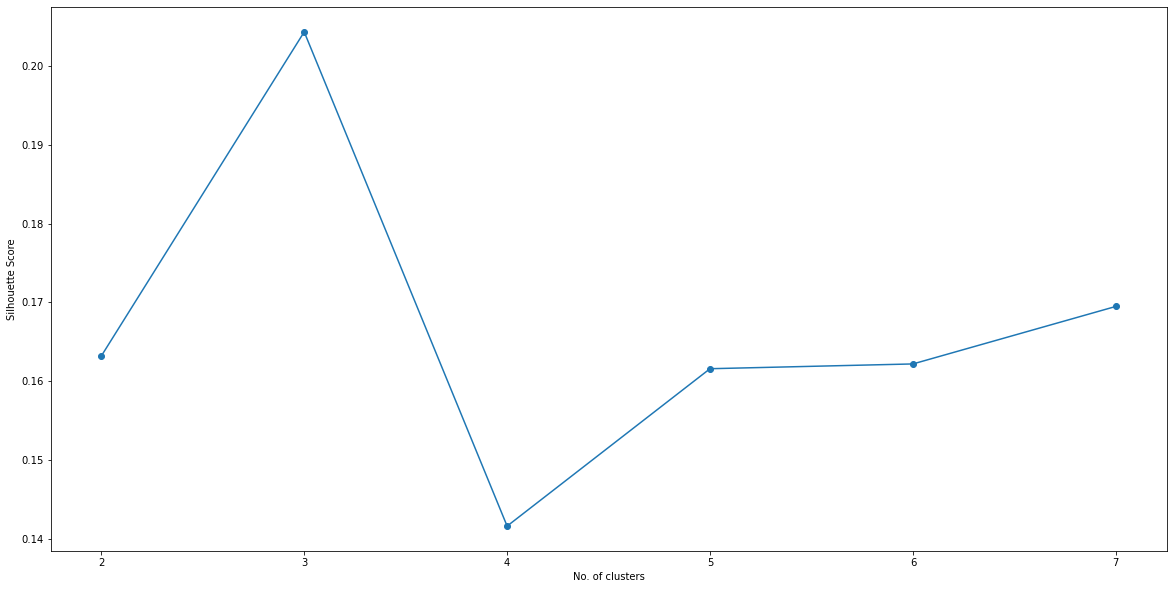

In [43]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [44]:
# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ALK_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 2, 2, 1, 0, 2, 0, 0])

In [45]:
# add clustering labels
ALK_neighbour_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ALK_final = AKL_merge

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ALK_final = ALK_final.join(ALK_neighbour_venues_sorted.set_index('Neighbourhoods'), on='Neighbourhoods')

ALK_final.head() # check the last columns!

,Neighbourhoods,PostCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Blockhouse Bay,0600,-36.918,174.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kelston,0602,-36.898,174.660,0.0,Café,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
2,Huia,0604,-36.998,174.567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,McLaren Park,0612,-36.888,174.610,1.0,Indian Restaurant,Malay Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop,Filipino Restaurant
4,Swanson,0614,-36.867,174.583,0.0,Fish & Chips Shop,Café,Pizza Place,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court


In [46]:
ALK_final.isnull().values.any()

True

In [47]:
AKL_dropNAN = ALK_final.dropna()

In [48]:
AKL_dropNAN.isnull().values.any()

False

In [49]:
AKL_dropNAN = AKL_dropNAN[['PostCode', 'Neighbourhoods', 'Latitude', 'Longitude', 'Cluster Labels', '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue']]

In [50]:
AKL_dropNAN.head(10)

,PostCode,Neighbourhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0602,Kelston,-36.898,174.660,0.0,Café,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
3,0612,McLaren Park,-36.888,174.610,1.0,Indian Restaurant,Malay Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop,Filipino Restaurant
4,0614,Swanson,-36.867,174.583,0.0,Fish & Chips Shop,Café,Pizza Place,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
6,0620,Forrest Hill,-36.764,174.748,2.0,Korean Restaurant,Bakery,Fish & Chips Shop,Chinese Restaurant,Yakitori Restaurant,Donut Shop,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant
7,0622,Belmont,-36.807,174.786,2.0,Pizza Place,Fast Food Restaurant,Café,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
8,0624,Devonport,-36.828,174.790,0.0,Café,Japanese Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
10,0629,Marlborough,-36.778,174.720,2.0,Fast Food Restaurant,Japanese Restaurant,Donut Shop,Burger Joint,Ramen Restaurant,Sandwich Place,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
11,0632,Greenhithe,-36.767,174.683,0.0,Café,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
12,0640,New Lynn,-36.907,174.687,2.0,Café,Fast Food Restaurant,Pizza Place,Vietnamese Restaurant,Mongolian Restaurant,Portuguese Restaurant,Restaurant,Burger Joint,Malay Restaurant,Breakfast Spot
13,0642,Titirangi,-36.938,174.656,0.0,Café,Indian Restaurant,Restaurant,Pizza Place,Fast Food Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Filipino Restaurant


In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(AKL_dropNAN['Latitude'], AKL_dropNAN['Longitude'], AKL_dropNAN['Neighbourhoods'], AKL_dropNAN['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1], #cluster-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1], #cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [52]:
AKL_dropNAN.loc[AKL_dropNAN['Cluster Labels'] == 0, AKL_dropNAN.columns[[1] + list(range(5, AKL_dropNAN.shape[1]))]]

,Neighbourhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Kelston,Café,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
4,Swanson,Fish & Chips Shop,Café,Pizza Place,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
8,Devonport,Café,Japanese Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
11,Greenhithe,Café,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
13,Titirangi,Café,Indian Restaurant,Restaurant,Pizza Place,Fast Food Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Filipino Restaurant
14,Green Bay,Café,Asian Restaurant,Bakery,Yakitori Restaurant,Fish & Chips Shop,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
19,Swanson,Fish & Chips Shop,Café,Pizza Place,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
20,Swanson,Fish & Chips Shop,Café,Pizza Place,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
25,Hauraki,Café,Indian Restaurant,Bakery,Yakitori Restaurant,Donut Shop,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
26,Milford,Café,Indian Restaurant,Italian Restaurant,Chinese Restaurant,Malay Restaurant,Japanese Restaurant,Bakery,French Restaurant,Sushi Restaurant,Thai Restaurant


In [53]:
AKL_dropNAN.loc[AKL_dropNAN['Cluster Labels'] == 1, AKL_dropNAN.columns[[1] + list(range(5, AKL_dropNAN.shape[1]))]]

,Neighbourhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,McLaren Park,Indian Restaurant,Malay Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop,Filipino Restaurant
33,Birkdale,Indian Restaurant,Bakery,Fast Food Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
37,Paremoremo,Indian Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop,Filipino Restaurant
70,Snells Beach,Indian Restaurant,Restaurant,Deli / Bodega,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop,Filipino Restaurant
151,Meadowbank,Indian Restaurant,Café,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
199,Otara,Indian Restaurant,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop,Filipino Restaurant


In [54]:
AKL_dropNAN.loc[AKL_dropNAN['Cluster Labels'] == 2, AKL_dropNAN.columns[[1] + list(range(5, AKL_dropNAN.shape[1]))]]

,Neighbourhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Forrest Hill,Korean Restaurant,Bakery,Fish & Chips Shop,Chinese Restaurant,Yakitori Restaurant,Donut Shop,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant
7,Belmont,Pizza Place,Fast Food Restaurant,Café,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court
10,Marlborough,Fast Food Restaurant,Japanese Restaurant,Donut Shop,Burger Joint,Ramen Restaurant,Sandwich Place,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
12,New Lynn,Café,Fast Food Restaurant,Pizza Place,Vietnamese Restaurant,Mongolian Restaurant,Portuguese Restaurant,Restaurant,Burger Joint,Malay Restaurant,Breakfast Spot
16,Glendene,Pizza Place,Thai Restaurant,BBQ Joint,Fish & Chips Shop,Yakitori Restaurant,Fast Food Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
17,Sunnyvale,Sushi Restaurant,Bakery,Yakitori Restaurant,Dim Sum Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
18,Te Atatu,Burger Joint,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
21,Massey East,Donut Shop,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop
22,West Harbour,Fast Food Restaurant,Pizza Place,Café,Cantonese Restaurant,Noodle House,Vietnamese Restaurant,Food Court,Sushi Restaurant,Bakery,Bistro
24,Massey East,Donut Shop,Yakitori Restaurant,Dim Sum Restaurant,Indian Restaurant,German Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Court,Fish & Chips Shop


### Part 2 - Analysis (Median Incomes): 


In [6]:
mean_df = Income_final_df[['Neighbourhood','Income_Median_2018']].groupby('Neighbourhood').mean().round(0)

In [7]:
stddev_df = Income_final_df[['Neighbourhood','Income_Median_2018']].groupby('Neighbourhood').std().round(0)

In [8]:
mean_df.columns = ['Income_mean']
mean_df.head()

,Income_mean
Neighbourhood,
Albany,33106.0
Albany Heights,33106.0
Algies Bay,30072.0
Arkles Bay,38915.0
Army Bay,36297.0


In [9]:
stddev_df.columns = ['Income_stddev']
stddev_df.head()

,Income_stddev
Neighbourhood,
Albany,8161.0
Albany Heights,8162.0
Algies Bay,5119.0
Arkles Bay,7703.0
Army Bay,6609.0


In [10]:
merge = pd.merge(mean_df,stddev_df, on = 'Neighbourhood', left_index = True)
merge.head(10)

,Income_mean,Income_stddev
Neighbourhood,,
Albany,33106.0,8161.0
Albany Heights,33106.0,8162.0
Algies Bay,30072.0,5119.0
Arkles Bay,38915.0,7703.0
Army Bay,36297.0,6609.0
Auckland Central,27557.0,15206.0
Avondale,31898.0,9229.0
Bayswater,44855.0,9372.0
Bayview,35189.0,6153.0


In [11]:
merge = pd.merge(merge,Income_final_df, on = 'Neighbourhood', left_index = True)
merge.head(10)

,Neighbourhood,Income_mean,Income_stddev,Income_Median_2018,Latitude,Longitude,PostCode
485718,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485719,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485720,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485721,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485722,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485723,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485724,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485725,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485726,Albany,33106.0,8161.0,11700,-36.732,174.699,0632
485727,Albany,33106.0,8161.0,11700,-36.732,174.699,0632


In [12]:
merge = merge.drop(['Income_Median_2018'], axis = 1)
print(merge.shape)
merge.head(10)

(1037005, 6)


,Neighbourhood,Income_mean,Income_stddev,Latitude,Longitude,PostCode
485718,Albany,33106.0,8161.0,-36.732,174.699,0632
485719,Albany,33106.0,8161.0,-36.732,174.699,0632
485720,Albany,33106.0,8161.0,-36.732,174.699,0632
485721,Albany,33106.0,8161.0,-36.732,174.699,0632
485722,Albany,33106.0,8161.0,-36.732,174.699,0632
485723,Albany,33106.0,8161.0,-36.732,174.699,0632
485724,Albany,33106.0,8161.0,-36.732,174.699,0632
485725,Albany,33106.0,8161.0,-36.732,174.699,0632
485726,Albany,33106.0,8161.0,-36.732,174.699,0632
485727,Albany,33106.0,8161.0,-36.732,174.699,0632


In [13]:
merge_df = merge.drop_duplicates()
print(merge_df.shape)
merge_df.head(10)

(30256, 6)


,Neighbourhood,Income_mean,Income_stddev,Latitude,Longitude,PostCode
485718,Albany,33106.0,8161.0,-36.732,174.699,0632
486177,Albany,33106.0,8161.0,-36.755,174.691,0632
486636,Albany,33106.0,8161.0,-36.734,174.709,0632
487095,Albany,33106.0,8161.0,-36.754,174.696,0632
487554,Albany,33106.0,8161.0,-36.720,174.716,0632
488013,Albany,33106.0,8161.0,-36.720,174.718,0632
488472,Albany,33106.0,8161.0,-36.723,174.716,0632
488931,Albany,33106.0,8161.0,-36.739,174.687,0632
489390,Albany,33106.0,8161.0,-36.741,174.691,0632
489849,Albany,33106.0,8161.0,-36.741,174.697,0632


In [14]:
merge_df = merge_df.drop_duplicates(['Neighbourhood'])
print(merge_df.shape)
merge_df.head(10)

(162, 6)


,Neighbourhood,Income_mean,Income_stddev,Latitude,Longitude,PostCode
485718,Albany,33106.0,8161.0,-36.732,174.699,0632
485806,Albany Heights,33106.0,8162.0,-36.732,174.699,0632
549226,Algies Bay,30072.0,5119.0,-36.430,174.722,0920
572730,Arkles Bay,38915.0,7703.0,-36.610,174.700,0932
551530,Army Bay,36297.0,6609.0,-36.630,174.768,0930
590904,Auckland Central,27557.0,15206.0,-36.858,174.766,1010
12,Avondale,31898.0,9229.0,-36.910,174.699,0600
305868,Bayswater,44855.0,9372.0,-36.789,174.766,0622
381217,Bayview,35189.0,6153.0,-36.778,174.707,0629
327884,Beach Haven,41684.0,8319.0,-36.791,174.693,0626


In [15]:
Cluster = merge_df[merge_df['Neighbourhood'].isin(['Birkdale', 'Paremoremo', 'Otara', 'Meadowbank', 'Snells Beach', 'McLaren Park']) ]

In [16]:
Cluster.dtypes

Neighbourhood     object
Income_mean      float64
Income_stddev    float64
Latitude         float64
Longitude        float64
PostCode          object
dtype: object

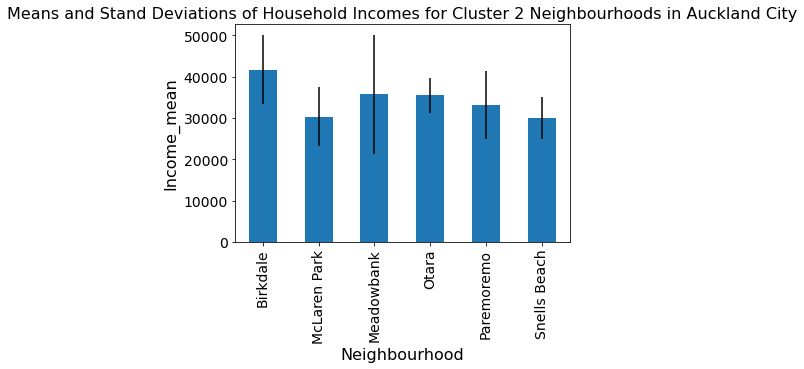

In [35]:
Cluster.plot(kind = "bar", y = "Income_mean", x = 'Neighbourhood', legend = False, yerr = "Income_stddev", fontsize=14) 
plt.ylabel("Income_mean", fontsize = 16),  
plt.xlabel("Neighbourhood", fontsize=16),
plt.title("Means and Stand Deviations of Household Incomes for Cluster 2 Neighbourhoods in Auckland City", fontsize=16)
font = {'family' : 'Times New Roman', 'weight' : 'bold'}
plt.show()

In [51]:
Cluster_stats = Income_final_df[Income_final_df['Neighbourhood'].isin(['Birkdale', 'Paremoremo', 'Otara', 'Meadowbank', 'Snells Beach', 'McLaren Park']) ]

In [52]:
Cluster_stats.isnull().values.any()

False

In [53]:
ans = Cluster_stats.groupby("Neighbourhood")['Income_Median_2018'].describe().reset_index()
ans

,Neighbourhood,count,mean,std,min,25%,50%,75%,max
0,Birkdale,5124.0,41683.606557,8318.946846,19800.0,36400.0,41800.0,47800.0,61200.0
1,McLaren Park,30178.0,30289.240506,7132.470791,10300.0,24400.0,29900.0,36000.0,50500.0
2,Meadowbank,5796.0,35715.527950,14451.863287,13500.0,22400.0,35200.0,45500.0,72200.0
3,Otara,60.0,35530.000000,4252.229724,29400.0,31775.0,34650.0,38150.0,43600.0
4,Paremoremo,2142.0,33105.555556,8162.100243,11700.0,26900.0,32700.0,39300.0,57700.0
5,Snells Beach,1984.0,30071.875000,5111.953432,21300.0,26800.0,29650.0,33275.0,45600.0


### Part 2 - Analysis (Distances between Auckland CBD and selected neighbourhoods):


In [54]:
from math import sin, cos, sqrt, atan2, radians
#radius of the Earth
R = 6373.0
# coordinates for Auckland CBD
CBD_lat = radians(-36.848)
CBD_long = radians(174.763)
Distance = []
for Latitude, Longitude in zip(Cluster.iloc[:, 3], Cluster.iloc[:, 4]):
    # coordinates for each neighbourhood
    lat = radians(Latitude)
    lon = radians(Longitude)
    # change in coordinates
    dlon = lon - CBD_long
    dlat = lat - CBD_lat
    # Haversine formula
    a = sin(dlat / 2)**2 + cos(CBD_lat) * cos(lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    dist = R * c
    dist = round(dist, 1)
    Distance.append(dist)         

In [56]:
#Cluster.iloc[:,6] = Distance 
Cluster.loc[:,"Km's"] = Distance

In [57]:
Cluster

,Neighbourhood,Income_mean,Income_stddev,Latitude,Longitude,PostCode,Km's
327941,Birkdale,41684.0,8319.0,-36.791,174.693,0626,8.9
175047,McLaren Park,30289.0,7132.0,-36.876,174.636,0612,11.7
892855,Meadowbank,35716.0,14452.0,-36.879,174.859,1072,9.2
990905,Otara,35530.0,4252.0,-36.921,174.908,2013,15.2
485988,Paremoremo,33106.0,8162.0,-36.732,174.699,0632,14.1
549236,Snells Beach,30072.0,5112.0,-36.430,174.722,0920,46.6


## Results and Discussion <a name="results_and_discussion"></a>

Foursquare revealed a total of 62 unique FOOD categories were identified in the 202 Auckland neighbourhoods that make up the greater Auckland City region.  This data set was reduced to just the top 10 venues food venues and the frequency in which they appeared in each neighbourhood.

K-means clustering reduced the neighbourhoods into 3 clusters with the 2nd cluster grouping six neighbourhoods: McLaren Park, Birkdale, Paremoremo, Meadowbank, Otara and Snells Beach together.  Cluster 2 revealed the category “Indian restaurant” as the most popular venue for people to visit.  A refined search of these six neighbourhoods showed that the density of Indian restaurants is low in all six neighbourhoods, with each only having one or two existing restaurants in the "Indian cuisine" category that would be considered in direct competition for customers.   

An examination of median household incomes showed Birkdale had the highest mean income (\\$41,684 ± 8,319.0), with Meadowbank (\\$35,716 ± 14,452.0) and Otara (\\$35,530 ± 4,252.0) having the second and third highest incomes.  While this might indicate disposable income it more investigation beyond the scope of this report should be conducted.   Household income does not reflect household debt, which would also be a factor in potential diners’ willingness to eat out at a fine dining restaurant.  

Due to the sprawl of neighbourhoods in Cluster 2, the distances of each neighbourhood from the city centre are added for the client’s consideration.  For the purposes of this report the Auckland CBD (central business district) has been used as the centre point.  Of the six neighbourhoods, Birkdale and Meadowbank are the most central to the city at 8.9 km’s and 9.2 km’s respectively.  Snells Beach is the most remote at 46.6 km.  While these distances are accurate (in a direct line) they are not realistic of how far it is to drive between any of the two given points.  Therefore, the distance between the CBD and each neighbourhood via the most direct road route using Google maps has been added in the table below.  

| Neighbourhood | Direct Distance (Km's) <sup>1| Distance via road (Km's) <sup>2|
|:--------------|:-----------------------:|:--------------------------:|
|McLaren Park|11.7|18.9|
|Birkdale|8.9|12.6|
|Paremoremo|14.1|25.3|
|Meadowbank|9.2|10.1|
|Otara|15.2|18|
|Snells Beach|46.6|66.6|

<br>Table of Neighbourhoods in Cluster 2 and their respective distances in kilometres from Auckland CBD.
<br>1: Distance calculated as a direct line between latitude and longitude points.
<br>2: Distance calculated by most direct driving route, as determined by Googlemaps.com  

Looking at the distances in the above table, Birkdale and Meadowbank are the most central neighbourhoods and Snells Beach the most removed from the city centre. 

## Conclusion <a name="conclusion"></a>

The purpose of this project was to find neighbourhoods within Auckland City where Indian cuisine is rated amongst the top venues sort out by diners.  Using Foursquare data, the search was reduced to a cluster of six areas, Birkdale, Meadowbank, Otara, Snells Beach and McLaren Park.  Foursquare also revealed a relatively light density of Indian cuisine restaurants in all these neighbourhoods, with Meadowbank and Birkdale having the highest number.  Both neighbourhoods currently have two existing restaurants that might be considered in direct competition with the client’s business model.

Household incomes placed Birkdale and Meadowbank and Otara at the higher end of the six neighbourhoods and Snells Beach at the lower end.  In terms of distance from the city centre Meadowbank and Birkdale are the closest neighbourhoods and Snells Beach requiring the greatest distance to travel.

Based on the findings of this investigation I would recommend the client consider either the neighbourhoods of Birkdale or Meadowbank as possible locations for her new restaurant.  While both areas already have two Indian Restaurants which would indicate there is some competition, both locations are the most centrally located and are on the upper end of household incomes.   
Further information beyond the scope of this report would assist the client decide on the best location to open her first restaurant.  Such as commercial property availability and location, cost of property purchase or lease, purchase or rent of personal living arrangements (house).